In [37]:
import numpy as np
import json
from pathlib import Path
import open3d as o3d
from matplotlib import pyplot as plt
import seaborn as sns

In [38]:
data_path = Path(r"data\depth_frames.json")

with open(data_path, "r") as f:
    data = json.load(f)

len(data)

49

In [39]:
list(data[0].keys())
for k, v in data[0].items():
    if k == "depth":
        print(f"depth: {len(v)}x{len(v[0])}")
    else:
        print(f"{k}: {v}")

depth: 360x640
x_scale: 5.3
y_scale: 5.3
focal_length_x: 2887.0115
focal_length_y: 2887.0115
center_x: 1688.6938
center_y: 949.18616
skew: 0.0


In [40]:
class DepthImage:

    def __init__(self, depth, x_scale, y_scale, focal_length_x, focal_length_y, center_x, center_y, skew):
        self.depth = depth
        self.x_scale = x_scale
        self.y_scale = y_scale
        self.focal_length_x = focal_length_x
        self.focal_length_y = focal_length_y
        self.center_x = center_x
        self.center_y = center_y
        self.skew = skew


    def to_frame(self):
        pc = []
        for y, row in enumerate(self.depth):
            pc.append([])
            for x, val in enumerate(row):
                pc[-1].append(self._rectify(x, y, val))

        return np.array(pc)

    def _rectify(self, x, y, depth):
        x, y = x*self.x_scale, y*self.y_scale
        return [(y*self.focal_length_y + self.skew*x + self.skew*self.center_y - self.center_x*self.focal_length_y)*depth / (self.focal_length_x*self.focal_length_y), 
                (x - self.center_y)*depth/self.focal_length_y, 
                depth]

In [41]:
depth_images = [DepthImage(**x) for x in data]
frames = [x.to_frame() for x in depth_images]


<Axes: >

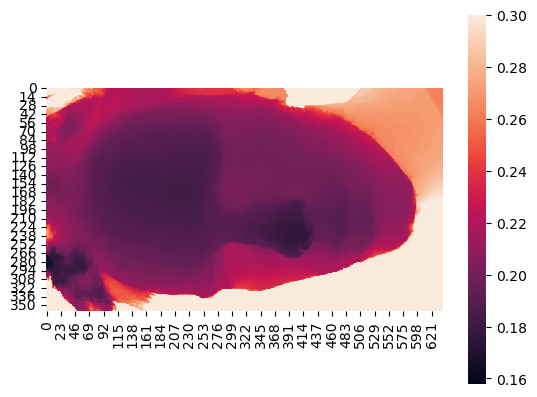

In [42]:
sns.heatmap(depth_images[10].depth, square=True, vmax=0.3)

In [43]:
for i in range(0, len(frames), 20):
    frame = frames[i].reshape((frames[i].shape[0]*frames[i].shape[1], frames[i].shape[2]))

    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(frame[frame[:,2] < 0.3])
    # o3d.visualization.draw_geometries([pc])

## Estimate normals

In [44]:
def estimate_normals(frame: np.ndarray, valid: np.ndarray, size=3, angle=55):
    angular_threshold = np.cos(np.deg2rad(angle))
    normals = np.zeros_like(frame)
    for i, row in enumerate(frame):
        for j, val in enumerate(row):
            if i < size or i >= len(frame) - size or j < size or j >= len(row) - size:
                valid[i, j] = False
            
            if valid[i][j]:
                dx = frame[i + size, j] - frame[i - size, j]
                dy = frame[i, j + size] - frame[i, j - size]

                normal = np.cross(dx, dy)
                normal = normal / np.linalg.norm(normal)
                normals[i, j] = normal

                cam_vec = frame[i, j] / np.linalg.norm(frame[i, j])

                if np.dot(cam_vec, normal) < angular_threshold:
                    valid[i][j] = 0
            else:
                normals[i,j] = np.array([0,0,1])

    return normals, valid

normals = []
valids = []

for frame in frames:
    frame_norms, frame_valid = estimate_normals(frame, np.ones((frame.shape[0], frame.shape[1]), bool), angle=75, size=5)
    normals.append(frame_norms)
    valids.append(frame_valid)

In [46]:
for i in range(0, len(frames), 5):
    frame = frames[i].reshape((frames[i].shape[0]*frames[i].shape[1], frames[i].shape[2]))
    valid = valids[i].flatten()
    normal = normals[i].reshape(frame.shape)
    accepted = np.logical_and((frame[:,2] < 0.3), valid)
    accepted_pc = o3d.geometry.PointCloud()
    accepted_pc.points = o3d.utility.Vector3dVector(frame[accepted])
    accepted_pc.normals = o3d.utility.Vector3dVector(normal[accepted])
    accepted_pc.paint_uniform_color([1, 0.706, 0])
    rejected_pc = o3d.geometry.PointCloud()
    rejected_pc.points = o3d.utility.Vector3dVector(frame[np.logical_and(~accepted, frame[:,2] < 0.6)])
    rejected_pc.normals = o3d.utility.Vector3dVector(normal[np.logical_and(~accepted, frame[:,2] < 0.6)])
    rejected_pc.paint_uniform_color([0, 0.651, 0.929])
    o3d.visualization.draw_geometries([accepted_pc, rejected_pc])
